<a href="https://colab.research.google.com/github/FahmidaAkterShimu/Final-Project-using-NLP/blob/main/Hate_Speech_Detection_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hate Speech Detection using LSTM**

In [1]:
# Importing libraries
import pandas as pd
import spacy
import numpy as np
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('/content/labeled_data.csv')

In [3]:
df.shape

(24783, 7)

In [4]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
df.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

In [6]:
# 1. DELETING UNWANTED COLUMNS
df.drop(columns = ['Unnamed: 0',	'count',	'hate_speech',	'offensive_language',	'neither'],
        inplace = True)

In [7]:
df.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [8]:
# 2. CHECKING FOR NULL VALUES
df.isna().sum()

,0
class,0
tweet,0


In [9]:
df['tweet'].iloc[0]

"!!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out..."

In [10]:
df['tweet'].iloc[100]

'"@ClicquotSuave: LMAOOOOOOOOOOO this nigga @Krillz_Nuh_Care http://t.co/AAnpSUjmYI" &lt;bitch want likes for some depressing shit..foh'

In [11]:
df['tweet'].iloc[1000]

'&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;&#128514;"@betysweetcocker: That pussy is just....&#128561; imma assume she just had a baby like..the day before"'

In [12]:
# 3. REPLACING SYMBOLS AND NUMBERS FROM TEXT
df['processed_tweet'] = df['tweet'].str.replace(r'[^a-zA-Z]', ' ', regex = True)

In [13]:
df.head()

,class,tweet,processed_tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...


In [14]:
df['processed_tweet'].iloc[1000]

'                                                                 betysweetcocker  That pussy is just              imma assume she just had a baby like  the day before '

In [15]:
# 4. REPLACING MULTIPLE WHITESPACE CHARACTERS WITH SINGLE ONE
df['processed_tweet_2'] = df['processed_tweet'].str.replace(r'[\s]+', ' ', regex = True)

In [16]:
df.head()

,class,tweet,processed_tweet,processed_tweet_2
0,2,!!! RT @mayasolovely: As a woman you shouldn't...,RT mayasolovely As a woman you shouldn t...,RT mayasolovely As a woman you shouldn t comp...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,RT mleew boy dats cold tyga dwn ba...,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,RT UrKindOfBrand Dawg RT sbaby...,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,RT C G Anderson viva based she lo...,RT C G Anderson viva based she look like a tr...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,RT ShenikaRoberts The shit you...,RT ShenikaRoberts The shit you hear about me ...


In [17]:
df['processed_tweet_2'].iloc[1000]

' betysweetcocker That pussy is just imma assume she just had a baby like the day before '

In [18]:
# Deleting unwanted columns
df.drop(columns = ['tweet', 'processed_tweet'], inplace = True)

In [19]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [20]:
# 5. REPLACING THE TARGET VALUES
# df['class'].replace({0 : 'hate', 1 : 'offensive', 2 : 'neither'}, inplace = True)

In [21]:
df.head()

,class,processed_tweet_2
0,2,RT mayasolovely As a woman you shouldn t comp...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...
3,1,RT C G Anderson viva based she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...


In [22]:
# Load out spacy modeule
nlp = spacy.load('en_core_web_sm')

In [23]:
# 6. LEMMATIZATION
def lemmatization(text):
  doc = nlp(text)
  lemmaList = [word.lemma_ for word in doc]
  return ' '.join(lemmaList)

In [24]:
df['lemma_tweet'] = df['processed_tweet_2'].apply(lemmatization)

In [25]:
df.head()

,class,processed_tweet_2,lemma_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...


In [26]:
df['processed_tweet_2'].iloc[67]

' Allyhaaaaa Lemmie eat a Oreo amp do these dishes One oreo Lol'

In [27]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [28]:
# 7. REMOVING STOPWORDS
def remove_stopwords(text):
  doc = nlp(text)
  no_stopwords_list = [word.text for word in doc if not word.is_stop]
  return ' '.join(no_stopwords_list)

In [29]:
df['final_tweet'] = df['lemma_tweet'].apply(remove_stopwords)

In [30]:
df['lemma_tweet'].iloc[67]

'  Allyhaaaaa Lemmie eat a Oreo amp do these dish one oreo lol'

In [31]:
df['final_tweet'].iloc[67]

'   Allyhaaaaa Lemmie eat Oreo amp dish oreo lol'

In [32]:
df.head()

,class,processed_tweet_2,lemma_tweet,final_tweet
0,2,RT mayasolovely As a woman you shouldn t comp...,RT mayasolovely as a woman you shouldn t com...,RT mayasolovely woman shouldn t complain cl...
1,1,RT mleew boy dats cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad for cuffi...,RT mleew boy dat cold tyga dwn bad cuffin d...
2,1,RT UrKindOfBrand Dawg RT sbaby life You ever ...,RT UrKindOfBrand Dawg RT sbaby life you ever...,RT UrKindOfBrand Dawg RT sbaby life fuck bi...
3,1,RT C G Anderson viva based she look like a tr...,RT C G Anderson viva base she look like a tr...,RT C G Anderson viva base look like tranny
4,1,RT ShenikaRoberts The shit you hear about me ...,RT ShenikaRoberts the shit you hear about I ...,RT ShenikaRoberts shit hear true faker bitc...


In [33]:
# 8. ONE - HOT REPRESENTATION

vocab_size = 10000
one_hot_representation = [one_hot(words, vocab_size) for words in df['final_tweet']]

In [34]:
df['final_tweet'].iloc[0]

'   RT mayasolovely woman shouldn t complain clean house amp man trash'

In [35]:
one_hot_representation[100]

[1376,
 2160,
 8223,
 6960,
 672,
 7282,
 3430,
 1549,
 9007,
 2209,
 8122,
 9949,
 5710,
 1589,
 3018,
 3418,
 776]

In [36]:
# 9. PADDING AND EMBEDDING

sentence_length = 20
embedded_tweet = pad_sequences(one_hot_representation, padding='pre', maxlen = sentence_length)

In [37]:
embedded_tweet[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0, 4954, 1693,
       4593, 2373, 1549, 4217,   73, 6068, 3826,  431,  182], dtype=int32)

In [38]:
for i in range (0,4):
  print(embedded_tweet[i])

[   0    0    0    0    0    0    0    0    0 4954 1693 4593 2373 1549
 4217   73 6068 3826  431  182]
[   0    0    0    0    0    0    0 4954 2423 8349 1912  969 1234 6178
 8550 5092 1912 1836   64 9556]
[   0    0    0    0    0    0    0    0 4954 8470 4979 4954 6973 3833
 5741 9949 2140 9789 8098 3418]
[   0    0    0    0    0    0    0    0    0    0    0 4954 6176 9650
 6324 6972 2935 2790 1589 6529]


In [39]:
# 10. DIVIDING THE DATASET
X = np.array(embedded_tweet)
y = np.array(df['class'])

In [40]:
df['class'].value_counts()

,count
class,
1,19190
2,4163
0,1430


In [41]:
smote = SMOTE(sampling_strategy='minority')
X, y = smote.fit_resample(X, y)

In [42]:
# 11. TRAIN - TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [43]:
X.shape, X_train.shape, X_test.shape

((42543, 20), (34034, 20), (8509, 20))

In [44]:
# 12. CREATING MODEL

dimension = 50

model = keras.Sequential([
    #embedding layer
    keras.layers.Embedding(vocab_size, dimension, input_length = sentence_length),
    # LSTM layer
    keras.layers.LSTM(100,return_sequences=True),
    keras.layers.LSTM(50, return_sequences=True),
    keras.layers.LSTM(50),
    #output layer
    keras.layers.Dense(3, activation = 'softmax')
])

#compilation
model.compile(optimizer = 'adam',
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.fit(X_train, y_train, epochs = 10, batch_size=32)

Epoch 1/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.7784 - loss: 0.5172
Epoch 2/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 46s 43ms/step - accuracy: 0.9428 - loss: 0.1746
Epoch 3/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 84s 45ms/step - accuracy: 0.9602 - loss: 0.1217
Epoch 4/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.9705 - loss: 0.0936
Epoch 5/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 81s 43ms/step - accuracy: 0.9787 - loss: 0.0728
Epoch 6/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 44ms/step - accuracy: 0.9840 - loss: 0.0507
Epoch 7/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.9894 - loss: 0.0335
Epoch 8/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 80s 43ms/step - accuracy: 0.9930 - loss: 0.0229
Epoch 9/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.9935 - loss: 0.0186
Epoch 10/10
1064/1064 ━━━━━━━━━━━━━━━━━━━━ 45s 43ms/step - accuracy: 0.9946 - loss: 0.0163


In [47]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Model Accuracy : {accuracy * 100}')

266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8938 - loss: 0.6112
Model Accuracy : 88.55329751968384


In [48]:
pred = np.argmax(model.predict(X_test), axis = -1)

266/266 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step


In [49]:
y_test[:5]

array([1, 1, 0, 1, 2])

In [50]:
pred[:5]

array([1, 1, 0, 1, 2])

In [51]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3812
           1       0.91      0.89      0.90      3807
           2       0.75      0.73      0.74       890

    accuracy                           0.89      8509
   macro avg       0.85      0.85      0.85      8509
weighted avg       0.89      0.89      0.89      8509



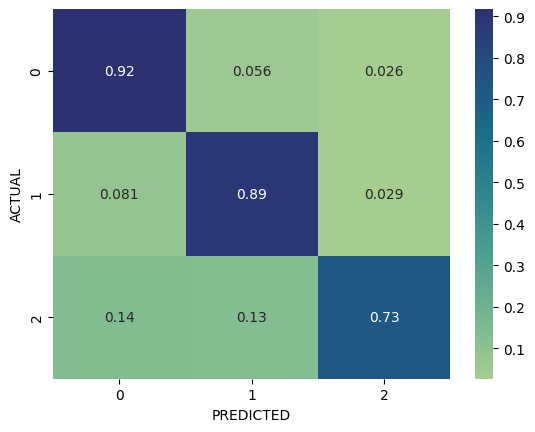

In [52]:
cf = confusion_matrix(y_test, pred, normalize = 'true')
sns.heatmap(cf, annot = True, cmap = 'crest')
plt.xlabel('PREDICTED'),
plt.ylabel('ACTUAL');